In [3]:
#!pip install kornia --upgrade
#!pip install pytorch_metric_learning

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import random
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from fastai2.basics import *
from fastcore import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastprogress import fastprogress
from fastai2.callback.mixup import *
from fastscript import *
import torchvision as tv
import kornia as K

def imshow_torch(tensor, *kwargs):
    plt.figure()
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

In [2]:
train_ds_name = 'liberty'
val_ds_name = 'notredame'
val_ds_name2 = 'yosemite'

ds_root = '/home/old-ufo/datasets/Brown/'

In [3]:
import os
import numpy as np
from PIL import Image
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
import torchvision
from torchvision.datasets import VisionDataset

from torchvision.datasets.utils import download_url



class PhotoTourRevisited(torchvision.datasets.VisionDataset):
    """`Learning Local Image Descriptors Data <http://phototour.cs.washington.edu/patches/default.htm>`_ Dataset.
    Args:
        root (string): Root directory where images are.
        name (string): Name of the dataset to load.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    urls = {
        'notredame_harris': [
            'http://matthewalunbrown.com/patchdata/notredame_harris.zip',
            'notredame_harris.zip',
            '69f8c90f78e171349abdf0307afefe4d'
        ],
        'yosemite_harris': [
            'http://matthewalunbrown.com/patchdata/yosemite_harris.zip',
            'yosemite_harris.zip',
            'a73253d1c6fbd3ba2613c45065c00d46'
        ],
        'liberty_harris': [
            'http://matthewalunbrown.com/patchdata/liberty_harris.zip',
            'liberty_harris.zip',
            'c731fcfb3abb4091110d0ae8c7ba182c'
        ],
        'notredame': [
            'http://icvl.ee.ic.ac.uk/vbalnt/notredame.zip',
            'notredame.zip',
            '509eda8535847b8c0a90bbb210c83484'
        ],
        'yosemite': [
            'http://icvl.ee.ic.ac.uk/vbalnt/yosemite.zip',
            'yosemite.zip',
            '533b2e8eb7ede31be40abc317b2fd4f0'
        ],
        'liberty': [
            'http://icvl.ee.ic.ac.uk/vbalnt/liberty.zip',
            'liberty.zip',
            'fdd9152f138ea5ef2091746689176414'
        ],
    }
    means = {'notredame': 0.4854, 'yosemite': 0.4844, 'liberty': 0.4437,
             'notredame_harris': 0.4854, 'yosemite_harris': 0.4844, 'liberty_harris': 0.4437}
    stds = {'notredame': 0.1864, 'yosemite': 0.1818, 'liberty': 0.2019,
            'notredame_harris': 0.1864, 'yosemite_harris': 0.1818, 'liberty_harris': 0.2019}
    lens = {'notredame': 468159, 'yosemite': 633587, 'liberty': 450092,
            'liberty_harris': 379587, 'yosemite_harris': 450912, 'notredame_harris': 325295}
    image_ext = 'bmp'
    info_file = 'info.txt'
    matches_files = 'm50_100000_100000_0.txt'
    img_info_files = 'interest.txt'

    def __init__(
            self, root: str, name: str, train: bool = False,
        transform: Optional[Callable] = None, download: bool = False
    ) -> None:
        super(PhotoTourRevisited, self).__init__(root)
        self.name = name
        self.data_dir = os.path.join(self.root, name)
        self.data_down = os.path.join(self.root, '{}.zip'.format(name))
        self.data_file = os.path.join(self.root, '{}.pt'.format(name))

        self.train = train
        self.mean = self.means[name]
        self.std = self.stds[name]

        if download:
            self.download()

        if not self._check_datafile_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        # load the serialized data
        self.data, self.labels, self.matches, self.img_idxs = torch.load(self.data_file)

    def __getitem__(self, index: int) -> Union[torch.Tensor, Tuple[Any, Any, torch.Tensor]]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (data1, data2, matches)
        """
        data = self.data[index]
        if self.transform is not None:
            data = self.transform(data)
        if self.train:
            return data
        return data, self.labels[index], self.img_idxs[index]

    def __len__(self) -> int:
        return self.lens[self.name]


    def _check_datafile_exists(self) -> bool:
        return os.path.exists(self.data_file)

    def _check_downloaded(self) -> bool:
        return os.path.exists(self.data_dir)

    def download(self) -> None:
        if self._check_datafile_exists():
            print('# Found cached data {}'.format(self.data_file))
            return

        if not self._check_downloaded():
            # download files
            url = self.urls[self.name][0]
            filename = self.urls[self.name][1]
            md5 = self.urls[self.name][2]
            fpath = os.path.join(self.root, filename)

            download_url(url, self.root, filename, md5)

            print('# Extracting data {}\n'.format(self.data_down))

            import zipfile
            with zipfile.ZipFile(fpath, 'r') as z:
                z.extractall(self.data_dir)

            os.unlink(fpath)

        # process and save as torch files
        print('# Caching data {}'.format(self.data_file))

        dataset = (
            read_image_file(self.data_dir, self.image_ext, self.lens[self.name]),
            read_info_file(self.data_dir, self.info_file),
            read_matches_files(self.data_dir, self.matches_files),
            read_interest_file(self.data_dir, self.img_info_files)
        )

        with open(self.data_file, 'wb') as f:
            torch.save(dataset, f)

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")


def read_image_file(data_dir: str, image_ext: str, n: int) -> torch.Tensor:
    """Return a Tensor containing the patches
    """

    def PIL2array(_img: Image.Image) -> np.ndarray:
        """Convert PIL image type to numpy 2D array
        """
        return np.array(_img.getdata(), dtype=np.uint8).reshape(64, 64)

    def find_files(_data_dir: str, _image_ext: str) -> List[str]:
        """Return a list with the file names of the images containing the patches
        """
        files = []
        # find those files with the specified extension
        for file_dir in os.listdir(_data_dir):
            if file_dir.endswith(_image_ext):
                files.append(os.path.join(_data_dir, file_dir))
        return sorted(files)  # sort files in ascend order to keep relations

    patches = []
    list_files = find_files(data_dir, image_ext)

    for fpath in list_files:
        img = Image.open(fpath)
        for y in range(0, 1024, 64):
            for x in range(0, 1024, 64):
                patch = img.crop((x, y, x + 64, y + 64))
                patches.append(PIL2array(patch))
    return torch.ByteTensor(np.array(patches[:n])).float()


def read_info_file(data_dir: str, info_file: str) -> torch.Tensor:
    """Return a Tensor containing the list of labels
       Read the file and keep only the ID of the 3D point.
    """
    labels = []
    with open(os.path.join(data_dir, info_file), 'r') as f:
        labels = [int(line.split()[0]) for line in f]
    return torch.LongTensor(labels)

def read_interest_file(data_dir: str, info_file: str) -> torch.Tensor:
    """Return a Tensor containing the list of image ids
       Read the file and keep only the ID of the image point.
    """
    labels = []
    with open(os.path.join(data_dir, info_file), 'r') as f:
        labels = [int(line.split()[0]) for line in f]
    return torch.LongTensor(labels)


def read_matches_files(data_dir: str, matches_file: str) -> torch.Tensor:
    """Return a Tensor containing the ground truth matches
       Read the file and keep only 3D point ID.
       Matches are represented with a 1, non matches with a 0.
    """
    matches = []
    with open(os.path.join(data_dir, matches_file), 'r') as f:
        for line in f:
            line_split = line.split()
            matches.append([int(line_split[0]), int(line_split[3]),
                            int(line_split[1] == line_split[4])])
    return torch.LongTensor(matches)

In [4]:
ds_root = '/home/old-ufo/datasets/Brown'
lib_ds = PhotoTourRevisited(ds_root,
                      'liberty',
                       train=False, 
                       download=False)

In [5]:
orig_size = 64
out_size = 32
test_aug = nn.Sequential( 
    K.Resize((out_size,out_size), interpolation='bicubic'))


In [6]:
BS = 1024
TEST_BS = 128
N_WORKERS = 4

from fastai2  import *
# We need to transform all images
class TupleAug(ItemTransform):
    def __init__(self, tfm):
        self.tfm = tfm
    def encodes(self, o): 
        out = []
        with torch.no_grad():
            for i,oi in enumerate(o):
                if i < len(o) - 2:
                    out.append(self.tfm(oi.float().unsqueeze(1)))
                else:
                    out.append(oi)
        return out
    
    


In [7]:
dl_train = TfmdDL(lib_ds,
                 device=torch.device('cuda:0'),
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(test_aug)], #two patches -> single tensor
                 bs=BS, num_workers=N_WORKERS,
                 shuffle = False)

patches, labels, img_labels  = dl_train.one_batch()


In [8]:
desc = K.feature.SIFTDescriptor(32, rootsift=True).to(torch.device('cuda:0'))

In [9]:
num_patches = len(dl_train.dataset)
descriptors = torch.zeros(num_patches, 128)
all_labels = torch.zeros(num_patches)
all_img_labels = torch.zeros(num_patches)

count = 0 

for patches, labels, img_labels in progress_bar(dl_train):
    with torch.no_grad():
        descs = desc(patches)
        descriptors[count:count+len(descs),:] = descs
        all_labels[count:count+len(descs)] = labels
        all_img_labels[count:count+len(descs)] = img_labels
        count+=len(descs)

In [10]:
from pytorch_metric_learning import losses, miners
Miner = miners.BatchHardMiner()


In [69]:
img_idxs = torch.unique(all_img_labels).long()
is_correct = []#torch.zeros(len(all_img_labels)).long()
snn_ratio =  []#torch.zeros(len(all_img_labels))

In [70]:

count = 0
for ii in progress_bar(img_idxs):
    with torch.no_grad():
        current_batch = all_img_labels == ii
        cur_descs = descriptors[current_batch]
        cur_labels = all_labels[current_batch]
        anc, pos, neg = Miner(cur_descs, cur_labels)
        NN = cur_labels.size(0)
        pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN)>0)
        pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
        anc_idxs = torch.nonzero(pos_matrix)[:,0]
        neg_idxs = neg[anc_idxs]
        
        pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
        neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
        correct = pos_dists <= neg_dists
        
        snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
        #print (correct.shape)
        is_correct.append(correct)
        snn_ratio.append(snn)
        count+=+len(anc_idxs)
is_correct = torch.cat(is_correct)
snn_ratio = torch.cat(snn_ratio)



    


In [73]:
ths =  np.linspace(0,1.0,20)

In [81]:
def average_acc_per_th(snn_ratio, is_correct, ths= np.linspace(0,1.0,20) ):
    out = []
    for prev_th, th in zip(ths[:-1], ths[1:]):
        mask = (snn_ratio>prev_th) & (snn_ratio <= th)
        #print (mask.sum())
        AA = is_correct[mask].float().mean()
        print (mask.sum().item(), AA.item())
        out.append(AA.item())
    return out
hardnet_acc_per_th = average_acc_per_th(snn_ratio, is_correct, ths= np.linspace(0,1.0,20) )
print (np.array(hardnet_acc_per_th[1:]).mean())

112999 0.0
9 0.2222222238779068
139 0.38129496574401855
667 0.5442278981208801
1964 0.6074337959289551
4328 0.6150646805763245
8428 0.5854295492172241
14063 0.5340965390205383
22318 0.4705170691013336
33887 0.4274795651435852
48357 0.39762598276138306
64367 0.38261842727661133
79988 0.36894282698631287
93251 0.37181371450424194
103500 0.3828599154949188
109994 0.3977580666542053
111455 0.4212103486061096
110805 0.44368937611579895
121881 0.5368022918701172
0.44950484650002587


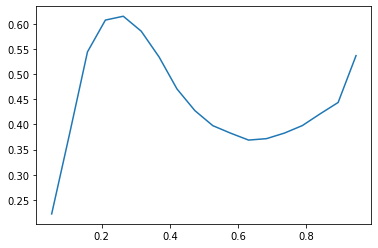

In [82]:
plt.plot(ths[1:-1], hardnet_acc_per_th[1:])

In [92]:
desc = K.feature.SIFTDescriptor(32, rootsift=False).to(torch.device('cuda:0'))
desc = K.feature.HardNet(True).to(torch.device('cuda:0'))
desc.eval()

HardNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): R

In [93]:
num_patches = len(dl_train.dataset)
descriptors = torch.zeros(num_patches, 128)
all_labels = torch.zeros(num_patches)
all_img_labels = torch.zeros(num_patches)

count = 0 

for patches, labels, img_labels in progress_bar(dl_train):
    with torch.no_grad():
        descs = desc(patches)
        descriptors[count:count+len(descs),:] = descs
        all_labels[count:count+len(descs)] = labels
        all_img_labels[count:count+len(descs)] = img_labels
        count+=len(descs)
img_idxs = torch.unique(all_img_labels).long()
is_correct = []#torch.zeros(len(all_img_labels)).long()
snn_ratio =  []#torch.zeros(len(all_img_labels))

count = 0
for ii in progress_bar(img_idxs):
    with torch.no_grad():
        current_batch = all_img_labels == ii
        cur_descs = descriptors[current_batch]
        cur_labels = all_labels[current_batch]
        anc, pos, neg = Miner(cur_descs, cur_labels)
        NN = cur_labels.size(0)
        pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN)>0)
        pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
        anc_idxs = torch.nonzero(pos_matrix)[:,0]
        neg_idxs = neg[anc_idxs]
        
        pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
        neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
        correct = pos_dists <= neg_dists
        
        snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
        #print (correct.shape)
        is_correct.append(correct)
        snn_ratio.append(snn)
        count+=+len(anc_idxs)
is_correct = torch.cat(is_correct)
snn_ratio = torch.cat(snn_ratio)


hn_acc_per_th = average_acc_per_th(snn_ratio, is_correct, ths= np.linspace(0,1.0,20) )
print (np.array(hn_acc_per_th[1:]).mean())
    


112999 0.0
39 0.7179487347602844
511 0.859099805355072
2368 0.8627533912658691
5724 0.9011180996894836
11035 0.889533281326294
18317 0.8933777213096619
27784 0.883350133895874
39215 0.8805049061775208
51281 0.8621127009391785
62274 0.8341522812843323
72407 0.8047288060188293
80016 0.7639597058296204
85919 0.7187583446502686
90490 0.666117787361145
92674 0.6116278767585754
92366 0.575190007686615
89350 0.5324006676673889
107631 0.598349928855896
0.769726898935106


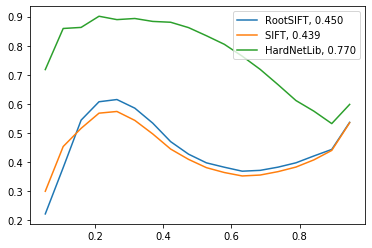

In [94]:
plt.plot(ths[1:-1], hardnet_acc_per_th[1:])
plt.plot(ths[1:-1], sift_acc_per_th[1:])
plt.plot(ths[1:-1], hn_acc_per_th[1:])

plt.legend([f'RootSIFT, {np.array(hardnet_acc_per_th[1:]).mean():.3f}',
            f'SIFT, {np.array(sift_acc_per_th[1:]).mean():.3f}',
            f'HardNetLib, {np.array(hn_acc_per_th[1:]).mean():.3f}',
           ])

In [ ]:

weights = ['model.state_dict',
           'HardNetLib_fastai2KorniaAug',
           'checkpoint_liberty_with_aug.pth',
           'sosnet-32x32-liberty.pth', 
           'tfeat-liberty.params']
models = [HardNet(), 
          HardNet(), 
          HardNet(),
          SOSNet32x32(), 
          TNet()]